# Klasyfikacja raka mózgu - Hubert Jaremko

## Proces przetwarzania danych

### Opis zestawu danych
Cheng, Jun (2017): brain tumor dataset. figshare. Dataset. https://doi.org/10.6084/m9.figshare.1512427.v5 

Zestaw danych zawiera 3064 obrazów z przewagą T1 pochodzących od 233 pacientów z trzema rodzajami nowotworów mózgu:
 - oponiak (*meningioma*, 708 obrazów), 
 - glejak (*glioma*, 1426 obrazów),
 - nowotwór przysadki (*pituitary tumor*, 930 obrazów).

Dane zostały zorganizowe w formacie matlaba (pliki `.mat`).
Każdy plik przechowuje strukture danych składającą się z następujących pól:
 - `cjdata.label`: `1` oznaczający oponiaka, `2` gelajka, `3` guz przysadki
 - `cjdata.PID`: ID pacjenta
 - `cjdata.image`: dane obrazu
 - `cjdata.tumorBorder`: wektor zawierajacy koordynaty punktów na granicy guza.
 - `cjdata.tumorMask`: obraz binarny, w którym jedynki oznaczają region guza

### Wczytanie obrazów

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
cancer_type = {1 : 'Oponiak', 2 : 'Glejak', 3 : 'Guz przysadki'}

In [3]:
def from_raw_pid(raw_pid):
    return ''.join([chr(c[0]) for c in raw_pid])

def from_raw_label(raw_label):
    return int(raw_label[0][0])

def from_raw(raw):
    return raw[0][0]

def from_raw_image(raw_image):
    return np.asarray(raw_image)

def read_raw_brain_data(index):
    import h5py
    brain_path = f'data/raw/{index}.mat'
    
    with h5py.File(brain_path, 'r') as file:
        image = from_raw_image(list(file['cjdata']['image']))
        label = from_raw_label(list(file['cjdata']['label']))
        return (image, label)
    return None

In [4]:
data_amount = 3064
# data_amount = 500
# start_i = 690
start_i = 1
brains_data = [read_raw_brain_data(i) for i in range(start_i, start_i + data_amount)]

In [5]:
def plot_images(columns, rows, data):
    fig = plt.figure(figsize=(16, 16))
    for i in range(1, columns * rows + 1):
        img = data[i][0].T
        ax = fig.add_subplot(rows, columns, i)
        ax.set_title(cancer_type[data[i][1]], fontsize=20)
        ax.set_yticks([])
        ax.set_xticks([])
        plt.imshow(img, cmap='gray')
    plt.show()

In [6]:
def filter_by_type(t):
    return list(filter(lambda x: x[1] == t, brains_data))

type_1 = filter_by_type(1)
type_2 = filter_by_type(2)
type_3 = filter_by_type(3)
print(f"Type 1 images: {len(type_1)}")
print(f"Type 2 images: {len(type_2)}")
print(f"Type 3 images: {len(type_3)}")

Type 1 images: 708
Type 2 images: 1426
Type 3 images: 930


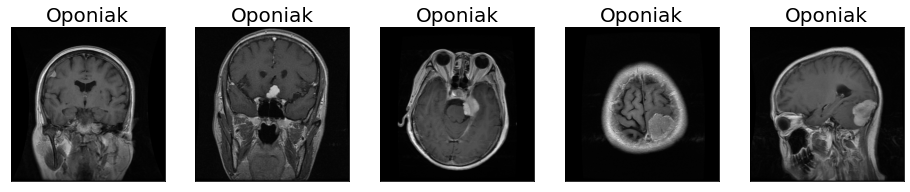

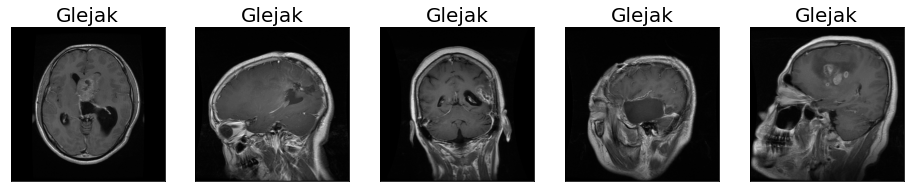

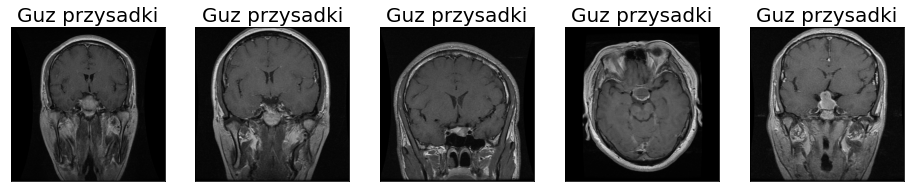

In [7]:
import random

random.shuffle(type_1)
random.shuffle(type_2)
random.shuffle(type_3)

plot_images(5, 1, type_1)
plot_images(5, 1, type_2)
plot_images(5, 1, type_3)

In [8]:
def plot_data_dist(type_1, type_2, type_3):
    df = pd.DataFrame(data={'Zestawy danych': [len(type_1), len(type_2), len(type_3)]}, index=[cancer_type[1], cancer_type[2], cancer_type[3]])
    df.plot(kind='bar', rot=0, legend=None)
    plt.title("Ilość zestawów danych ze wględu na rodzaj guza")
    plt.show()

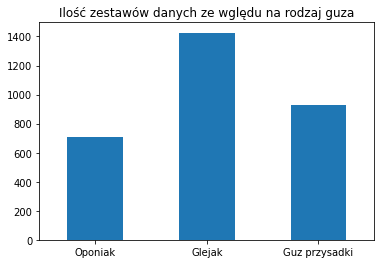

In [9]:
plot_data_dist(type_1, type_2, type_3)

In [3]:
import matplotlib.image as mpimg

In [4]:
for i, img in enumerate(type_1):
    mpimg.imsave(f'data/extracted/1/{i}.jpg', img[0].T, cmap='gray')

for i, img in enumerate(type_2):
    mpimg.imsave(f'data/extracted/2/{i}.jpg', img[0].T, cmap='gray')

for i, img in enumerate(type_3):
    mpimg.imsave(f'data/extracted/3/{i}.jpg', img[0].T, cmap='gray')

NameError: name 'type_1' is not defined

### Preprocessing
Ze względu na duży rozmiar obrazów oraz nierówny rozkład klas nowotworu (zob. wykres) zostaną wykonanne następujące kroki:
- Kompresja oraz przycięcie obrazów do rozmiaru 256 $\times$ 256.
- Uzupełnienie brakujących klas nowotwórów przez wzorst danych.

In [250]:
from os import walk

_, _, type_1_filenames = next(walk('data/extracted/1/'))
_, _, type_2_filenames = next(walk('data/extracted/2/'))
_, _, type_3_filenames = next(walk('data/extracted/3/'))

In [251]:
from PIL import Image

# dim = 100
dim = 50

def read_brains(data, source, filenames, t):
    for filename in filenames:
        image = Image.open(f'data/{source}/{t}/{filename}').convert('L')
        image = image.crop((50, 50, 450, 450))
        # image = image.resize((dim, dim))
        img = np.array(image)
        # img = mpimg.imread(f'data/extracted/{t}/{filename}')
        data.append((img, t))

In [252]:
brains_data = []

read_brains(brains_data, 'extracted', type_1_filenames, 1)
read_brains(brains_data, 'extracted', type_2_filenames, 2)
read_brains(brains_data, 'extracted', type_3_filenames, 3)

In [253]:
# _, _, additional_type_1_filenames = next(walk('data/training/1/'))
# _, _, additional_type_2_filenames = next(walk('data/training/2/'))
# _, _, additional_type_3_filenames = next(walk('data/training/3/'))

# read_brains('training', additional_type_1_filenames, 1)
# read_brains('training', additional_type_2_filenames, 2)
# read_brains('training', additional_type_3_filenames, 3)

In [254]:
brains = pd.DataFrame(data=brains_data, columns=['image', 'tumor_class'])
print(brains.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3064 entries, 0 to 3063
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        3064 non-null   object
 1   tumor_class  3064 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.0+ KB
None


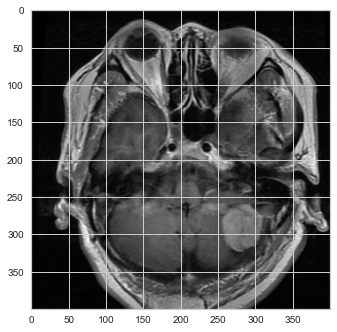

In [255]:
plt.imshow(brains['image'][0], cmap='gray')

[   0  708 1426  930]


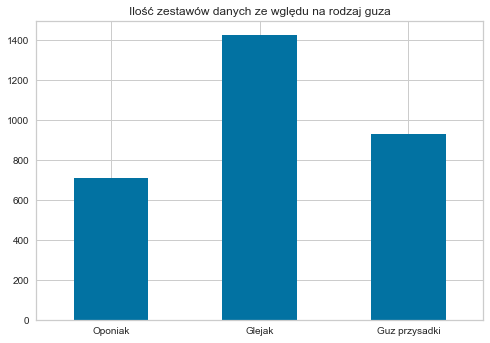

In [256]:
def plot_data_dist2(type_1, type_2, type_3):
    df = pd.DataFrame(data={'Zestawy danych': [type_1, type_2, type_3]}, index=[cancer_type[1], cancer_type[2], cancer_type[3]])
    df.plot(kind='bar', rot=0, legend=None)
    plt.title("Ilość zestawów danych ze wględu na rodzaj guza")
    plt.show()

counts = np.bincount(brains['tumor_class'].values)
print(counts)
plot_data_dist2(counts[1], counts[2], counts[3])

In [257]:
samples = 256

t1 = brains['tumor_class'] == 1
t2 = brains['tumor_class'] == 2
t3 = brains['tumor_class'] == 3
t1 = brains.loc[t1].sample(samples)
t2 = brains.loc[t2].sample(samples)
t3 = brains.loc[t3].sample(samples)

brains = t1.append([t2, t3])

[  0 256 256 256]


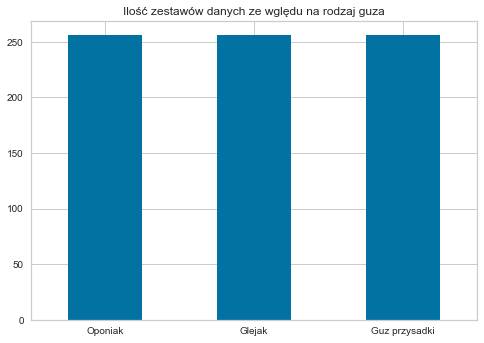

In [258]:
counts = np.bincount(brains['tumor_class'].values)
print(counts)
plot_data_dist2(counts[1], counts[2], counts[3])

### Dodanie etykiet

In [259]:
X = brains.drop(['tumor_class'], axis=1)
y = brains['tumor_class'].values

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))

X.shape: (768, 1) y.shape: (768,)


### Pipeline

In [260]:
from sklearn.base import BaseEstimator, TransformerMixin

In [261]:
# class DataFrameSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, attribute_names):
#         self.attribute_names = attribute_names
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return X[self.attribute_names]

In [262]:
# class Compresser(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         return X

In [263]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# class Augmenter(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
        
#         imgs = np.array(X['image'].tolist())
#         # print(np.array(X).shape)
#         # x = np.expand_dims(img, 0)
#         # x = np.expand_dims(x, 0)
#         # x.shape
#         y = np.asarray([1])

#         datagen = ImageDataGenerator(
#             width_shift_range=0.1,  # przesunięcie wzdłuż osi x
#             height_shift_range=0.1, # przesunięcie wzdłuż osi y
#             rotation_range=20,      # rotacja
#             horizontal_flip=True,   # odwrócenie poziome
#             vertical_flip = True,   # odwrócenie pionowe
#             rescale=1./255,         # parametr niezbędny, aby dobrze zwizualizować dane
#             shear_range=0.05,       # przycinanie obrazu
#             zoom_range=0.05,        # zoom
#         )

#         # # figure = plt.figure()
#         # i = 0
#         # for x_batch, y_batch in datagen.flow(x, y):
#         #     # a = figure.add_subplot(5, 5, i + 1)
#         #     new_img = np.squeeze(x_batch);
#         #     # plt.imshow(new_img)
#         #     yield new_img
#         #     # a.axis('off')
#         #     if i == 1: break
#         #     i += 1
#         # figure.set_size_inches(np.array(figure.get_size_inches()) * 3)
#         # plt.show()

#         return X

In [264]:
# dim = 256
# dim = 128

from skimage.transform import resize

class Flattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        arr = np.array([resize(x, (dim, dim)) for x in X['image'].values])
        return arr.reshape((-1, dim * dim))

In [265]:

# class Reshaper(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self
#     def transform(self, X):
#         X = np.array([resize(x, (512, 512)) for x in X['image'].values])
#         return X

In [266]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        # ("augment_images", Augmenter()),
        ("flatten_image", Flattener()),
    ])

In [267]:
preprocess_pipeline.fit_transform(X[:1]).shape

(1, 2500)

## Proces modelowania

In [268]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from scipy.stats.distributions import uniform, randint

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [270]:
# X_train =  np.expand_dims(X_train, axis=1)
print("X.shape: {} y.shape: {}".format(X_train.shape, y_train.shape))

X.shape: (537, 1) y.shape: (537,)


In [271]:
seed=123
# kfold = StratifiedKFold(n_splits=5, shuffle=False, random_state=seed)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

#### SVC linear

In [272]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel='linear', probability=True))])


param_grid = {
            # 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
            'classifier__C': [0.01]
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise')
# grid_1 = GridSearchCV(pipe, param_grid, cv=kfold)

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 0.01}

In [273]:
#### SVM rbf

In [274]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel='rbf', probability=True))])


param_grid = {
            # 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
            'classifier__C': [0.01, 0.1, 1]
}

param_distributions = {
    # 'max_depth': randint(3, 11),
    # 'learning_rate': uniform(0.001, 0.1-0.001),
    # 'n_estimators': randint(50, 400),
    'classifier__gamma': uniform(0,2),
    # 'colsample_bytree': uniform(0.5, 0.5),
    # 'subsample': uniform(0.5, 0.5),
    # 'min_child_weight': randint(1, 11)
    'classifier__C': uniform(0.001, 100)
}

grid_2 = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise')
# grid_2 = RandomizedSearchCV(n_iter=5, estimator=pipe, cv=kfold, param_distributions=param_distributions, return_train_score=True, error_score='raise')

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__C': 1}

#### SVM poly

In [275]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel='poly', probability=True))])


param_grid = {
            # 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
            'classifier__C': [0.01, 0.1, 1]
}

param_distributions = {
    # 'max_depth': randint(3, 11),
    # 'learning_rate': uniform(0.001, 0.1-0.001),
    # 'n_estimators': randint(50, 400),
    'classifier__gamma': uniform(0,2),
    # 'colsample_bytree': uniform(0.5, 0.5),
    # 'subsample': uniform(0.5, 0.5),
    # 'min_child_weight': randint(1, 11)
    'classifier__C': uniform(0.001, 100)
}

grid_3 = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise')
# grid_3 = RandomizedSearchCV(n_iter=5, estimator=pipe, cv=kfold, param_distributions=param_distributions, return_train_score=True, error_score='raise')

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__C': 0.1}

#### Logistic Regression

In [276]:
from sklearn import linear_model

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', linear_model.LogisticRegression())])


param_grid = {
            # 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
            'classifier__C': [0.01, 0.1, 1]
}

param_distributions = {
    # 'max_depth': randint(3, 11),
    # 'learning_rate': uniform(0.001, 0.1-0.001),
    # 'n_estimators': randint(50, 400),
    'classifier__gamma': uniform(0,2),
    # 'colsample_bytree': uniform(0.5, 0.5),
    # 'subsample': uniform(0.5, 0.5),
    # 'min_child_weight': randint(1, 11)
    'classifier__C': uniform(0.001, 100)
}

grid_4 = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise')
# grid_4 = RandomizedSearchCV(n_iter=5, estimator=pipe, cv=kfold, param_distributions=param_distributions, return_train_score=True, error_score='raise')

grid_4.fit(X_train, y_train)
grid_4.best_params_

arn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Hubert\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'classifier__C': 0.1}

#### Decision Tree
#### Random Forest
#### AdaBoost
#### GradientBoosting

#### Keras

In [301]:
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import History

history = History()

def create_model():
    model = Sequential()
    model.add(Dense(200,activation="sigmoid", input_shape=(X_train.shape[1],)))
    model.add(Dense(50,activation="sigmoid"))
    model.add(Dense(10,activation="sigmoid"))
    model.add(Dense(3,activation="sigmoid"))
    # model.summary()
    model = model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])
    return model


In [310]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

clf = KerasRegressor(build_fn=create_model)

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', clf)]
)

param_grid = {
            'classifier__validation_data': (X_test, y_test),
            'classifier__batch_size': 32,
            'classifier__epochs': 100
}

In [312]:
# x = np.asarray(X_train).astype('float32')
# y = np.asarray(y_train).astype('float32')
# history = model.fit(x, y, validation_data= (X_test, y_test), batch_size=32, epochs=100)
# X_train.head()
pipe.fit(X_train, y_train)

AttributeError: 'NoneType' object has no attribute 'loss'

## Porównanie modeli

In [277]:
from sklearn import  metrics

models = []
models.append(('svm_linear', grid_1.best_estimator_))
models.append(('svm_rbf', grid_2.best_estimator_))
models.append(('svm_poly', grid_3.best_estimator_))
models.append(('log_reg', grid_4.best_estimator_))

In [278]:
_, _, test_type_1_filenames = next(walk('data/testing/1/'))
_, _, test_type_2_filenames = next(walk('data/testing/2/'))
_, _, test_type_3_filenames = next(walk('data/testing/3/'))

X_test = []

read_brains(X_test, 'testing', test_type_1_filenames, 1)
read_brains(X_test, 'testing', test_type_2_filenames, 2)
read_brains(X_test, 'testing', test_type_3_filenames, 3)

b = pd.DataFrame(data=X_test, columns=['image', 'tumor_class'])
X_test = b.drop(['tumor_class'], axis=1)
y_test = b['tumor_class'].values

y_test = label_encoder.fit_transform(y_test)

print("X.shape: {} y.shape: {}".format(X.shape, y.shape))
# X_test.head()

X.shape: (768, 1) y.shape: (768,)


In [279]:
predictions = {}

for name, model in models:
    predictions[name] = model.predict(X_test)

In [280]:
precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
for name, model in models:
    precision_score.append(metrics.precision_score(y_test, predictions[name], average='macro'))
    recall_score.append(metrics.recall_score(y_test, predictions[name], average='macro'))
    f1_score.append( metrics.f1_score(y_test, predictions[name], average='macro'))
    accuracy_score.append(metrics.accuracy_score(y_test, predictions[name]))

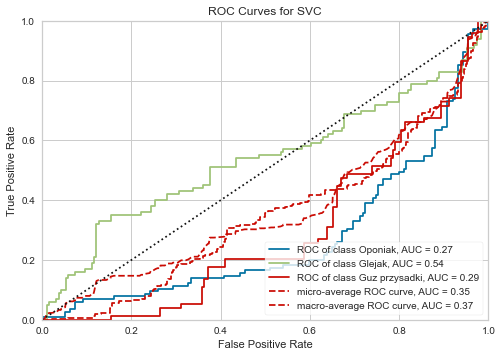

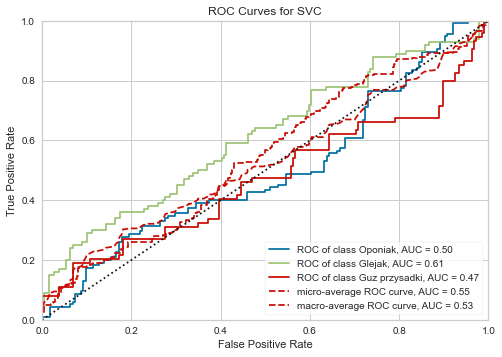

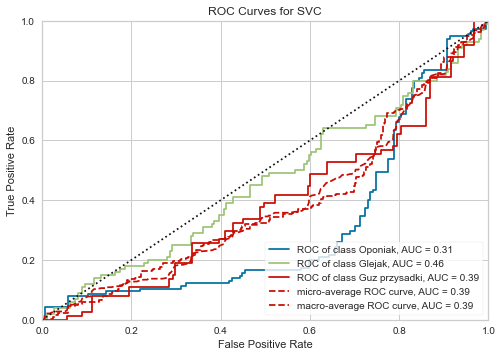

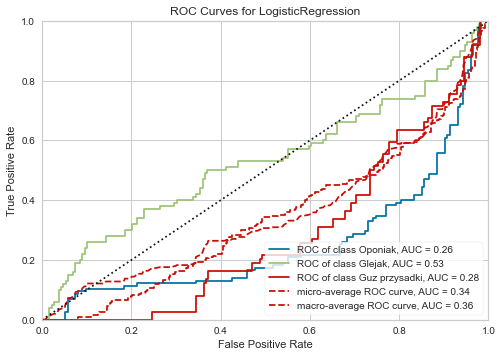

In [281]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model):
    visualizer = ROCAUC(model, encoder={0: cancer_type[1], 
                                        1: cancer_type[2], 
                                        2: cancer_type[3]})
                                        
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer

for _, model in models:
    plot_ROC_curve(model)

In [282]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score
    }
df = pd.DataFrame(data=d)
# df.insert(loc=0, column='Method', value=['SVM linear'])
# df.insert(loc=0, column='Method', value=['SVM linear', 'SVM rbf'])
# df.insert(loc=0, column='Method', value=['SVM linear', 'SVM rbf', 'SVM poly'])
df.insert(loc=0, column='Method', value=['SVM linear', 'SVM rbf', 'SVM poly', 'log reg'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,SVM linear,0.327405,0.273850,0.217396,0.235294
1,SVM rbf,0.473116,0.334132,0.313361,0.332180
2,SVM poly,0.249498,0.266780,0.246899,0.256055
3,log reg,0.309898,0.247622,0.226357,0.224913


## Wizualizacja wyników

  2 62]
 [52 14 34]
 [42  1 31]]
Classification report for classifier svm_poly:
              precision    recall  f1-score   support

           0       0.23      0.11      0.15       115
           1       0.31      0.39      0.35       100
           2       0.20      0.30      0.24        74

    accuracy                           0.26       289
   macro avg       0.25      0.27      0.25       289
weighted avg       0.25      0.26      0.24       289


Confusion matrix:
[[13 58 44]
 [18 39 43]
 [25 27 22]]
Classification report for classifier log_reg:
              precision    recall  f1-score   support

           0       0.21      0.13      0.16       115
           1       0.55      0.18      0.27       100
           2       0.17      0.43      0.25        74

    accuracy                           0.22       289
   macro avg       0.31      0.25      0.23       289
weighted avg       0.32      0.22      0.22       289


Confusion matrix:
[[15  8 92]
 [21 18 61]
 [35  7 32]]


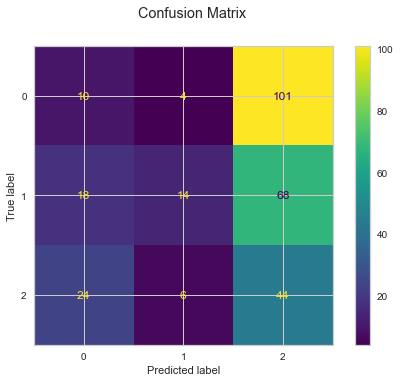

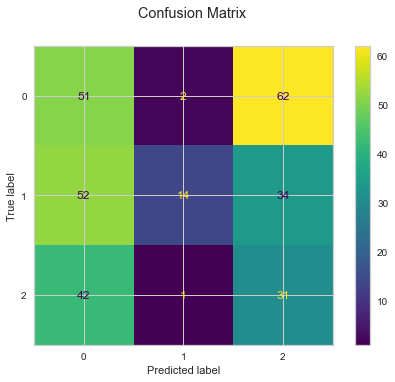

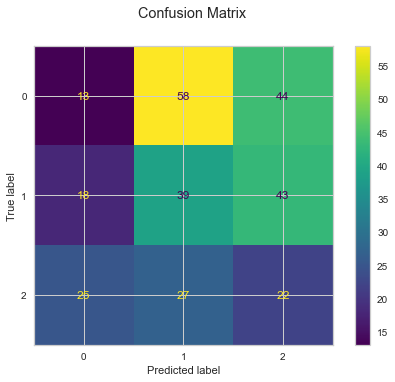

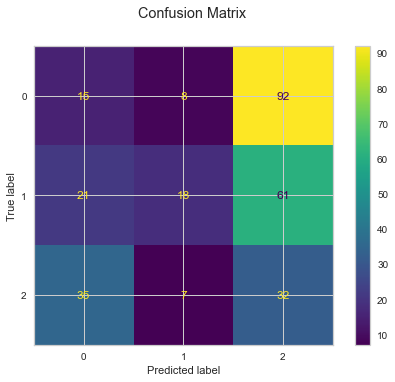

In [283]:
from sklearn import metrics

for name, model in models:
    print(f"Classification report for classifier {name}:\n"
        f"{metrics.classification_report(y_test, predictions[name])}\n")

    disp = metrics.plot_confusion_matrix(model, X_test, y_test)
    disp.figure_.suptitle("Confusion Matrix")
    print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

## Podsumowanie pracy

In [284]:
import joblib

for name, model in models:
    joblib.dump(model, f'{name}.model')

In [285]:
from PIL import Image
name, model = models[1]
# model = joblib.load('svm_linear.model')


# image = Image.open('image20.jpg').convert('L')
image = Image.open(f'data/extracted/3/1.jpg').convert('L')
img = np.array(image)
# img = X_test['image'][0]
# print(y_test[0])
print(img)

df = pd.DataFrame(data={'image': []})
df.loc[0] = [img]
df
# print(model.predict(X_test.head()))
print(model.predict(df)[0])


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1


In [286]:
predictions['svm_linear']

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 2, 0, 1,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 0], dtype=int64)